# BLE Proximity Experiment - Multi-Layered Perceptron Classifier
## Experiment based on the measurements of the BLE RSSI values according to the distance to the BLE Estimote beacon

### Imports
Imports of required libraries

In [1]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()
from pandas.plotting import scatter_matrix

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

<Figure size 432x288 with 0 Axes>

### Load File
Function that allows to load a file from disk

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

### Replace 0 with Nan RSSI Values

In [3]:
def replace_features_nan(dataset):
    dataset['rssi_Value'] = dataset['rssi_Value'].replace(0,np.nan)
    dataset['rolling_mean_rssi'] = dataset['rolling_mean_rssi'].replace(0,np.nan)

### Initialize Dataset
Initialization of the data from the file

In [4]:
dataset = load_file('../../dataset_train_university.csv')
positions = dataset['coordinate_Y']
dataset['distance'] = positions
replace_features_nan(dataset)
display(dataset)
display(dataset.shape)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-48,-48.000000,Personal,0.0
1,0.0,0.0,-48,-48.000000,Personal,0.0
2,0.0,0.0,-48,-48.000000,Personal,0.0
3,0.0,0.0,-48,-48.000000,Personal,0.0
4,0.0,0.0,-46,-47.600000,Personal,0.0
...,...,...,...,...,...,...
24829,0.0,4.5,-92,-90.480000,Public,4.5
24830,0.0,4.5,-93,-90.576923,Public,4.5
24831,0.0,4.5,-90,-90.555556,Public,4.5
24832,0.0,4.5,-90,-90.535714,Public,4.5


(24834, 6)

### Initialize Test Set

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,4.5,-86,-86.000000,Public,4.5
1,0.0,4.5,-84,-85.000000,Public,4.5
2,0.0,4.5,-83,-84.333333,Public,4.5
3,0.0,4.5,-84,-84.250000,Public,4.5
4,0.0,4.5,-92,-85.800000,Public,4.5
...,...,...,...,...,...,...
3672,0.0,0.0,-57,-56.814815,Personal,0.0
3673,0.0,0.0,-56,-56.785714,Personal,0.0
3674,0.0,0.0,-56,-56.758621,Personal,0.0
3675,0.0,0.0,-56,-56.733333,Personal,0.0


(3677, 6)

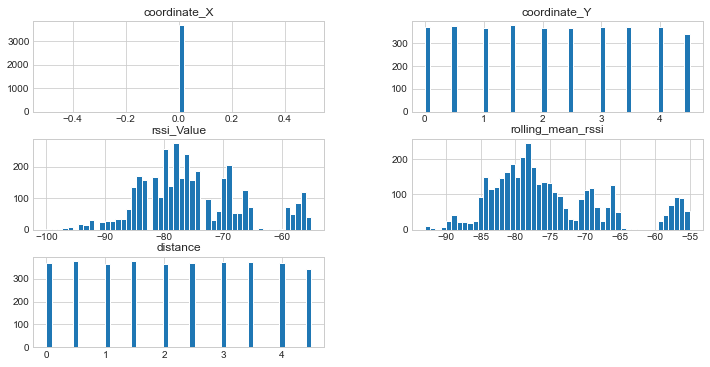

In [5]:
test_dataset = load_file('../../dataset_test_university.csv')
positions = test_dataset['coordinate_Y']
test_dataset['distance'] = positions
replace_features_nan(test_dataset)
display(test_dataset)
display(test_dataset.shape)
test_dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Initialize Test Set (HOME | BIG DATASET SAMSUNG)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-47,-47.000000,Personal,0.0
1,0.0,0.0,-46,-46.500000,Personal,0.0
2,0.0,0.0,-46,-46.333333,Personal,0.0
3,0.0,0.0,-47,-46.500000,Personal,0.0
4,0.0,0.0,-47,-46.600000,Personal,0.0
...,...,...,...,...,...,...
12470,0.0,3.5,-87,-84.555556,Social,3.5
12471,0.0,3.5,-87,-84.684211,Social,3.5
12472,0.0,3.5,-87,-84.800000,Social,3.5
12473,0.0,3.5,-87,-84.904762,Social,3.5


(12475, 6)

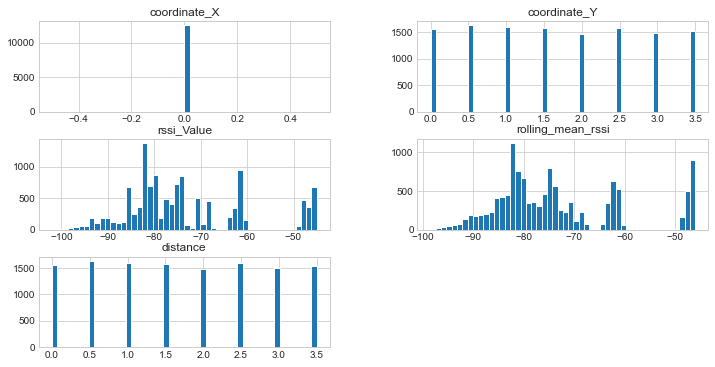

In [6]:
test_dataset_home_big = load_file('../../dataset_test_home_big.csv')
positions = test_dataset_home_big['coordinate_Y']
test_dataset_home_big['distance'] = positions
replace_features_nan(test_dataset_home_big)
display(test_dataset_home_big)
display(test_dataset_home_big.shape)
test_dataset_home_big.hist(bins=50,figsize=(12,6))
plt.show()

### Initialize Test Set (HOME | SMALL DATASET SAMSUNG)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-44,-44.000000,Personal,0.0
1,0.0,0.0,-44,-44.000000,Personal,0.0
2,0.0,0.0,-44,-44.000000,Personal,0.0
3,0.0,0.0,-44,-44.000000,Personal,0.0
4,0.0,0.0,-45,-44.200000,Personal,0.0
...,...,...,...,...,...,...
2279,0.0,3.5,-84,-83.944444,Social,3.5
2280,0.0,3.5,-85,-84.000000,Social,3.5
2281,0.0,3.5,-85,-84.050000,Social,3.5
2282,0.0,3.5,-92,-84.428571,Social,3.5


(2284, 6)

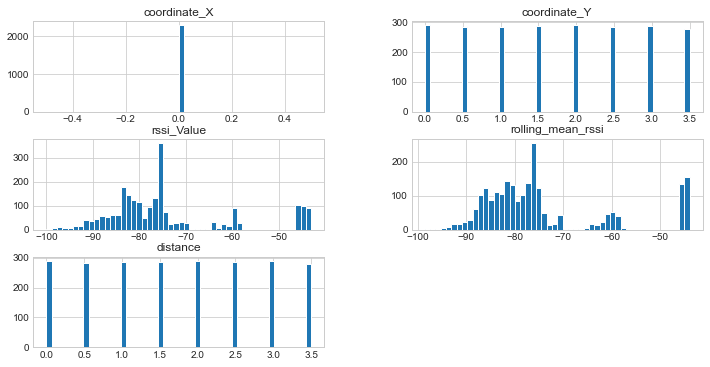

In [7]:
test_dataset_home_small = load_file('../../dataset_test_home.csv')
positions = test_dataset_home_small['coordinate_Y']
test_dataset_home_small['distance'] = positions
replace_features_nan(test_dataset_home_small)
display(test_dataset_home_small)
display(test_dataset_home_small.shape)
test_dataset_home_small.hist(bins=50,figsize=(12,6))
plt.show()

### Initialize Test Set (HOME | SMALL DATASET ASUS)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-50,-50.000000,Personal,0.0
1,0.0,0.0,-50,-50.000000,Personal,0.0
2,0.0,0.0,-53,-51.000000,Personal,0.0
3,0.0,0.0,-51,-51.000000,Personal,0.0
4,0.0,0.0,-53,-53.000000,Personal,0.0
...,...,...,...,...,...,...
410,0.0,3.5,-86,-83.800000,Social,3.5
411,0.0,3.5,-88,-84.500000,Social,3.5
412,0.0,3.5,-84,-84.428571,Social,3.5
413,0.0,3.5,-83,-84.250000,Social,3.5


(415, 6)

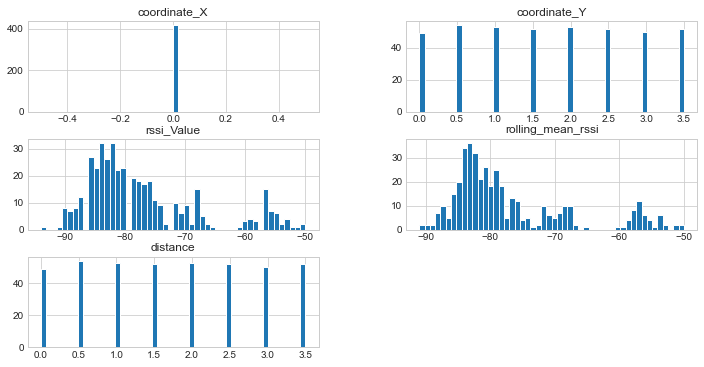

In [8]:
test_dataset_home_asus = load_file('../../dataset_test_home_asus.csv')
positions = test_dataset_home_asus['coordinate_Y']
test_dataset_home_asus['distance'] = positions
replace_features_nan(test_dataset_home_asus)
display(test_dataset_home_asus)
display(test_dataset_home_asus.shape)
test_dataset_home_asus.hist(bins=50,figsize=(12,6))
plt.show()

### Dataset Overall Info

In [9]:
display(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24834 entries, 0 to 24833
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   coordinate_X       24834 non-null  float64
 1   coordinate_Y       24834 non-null  float64
 2   rssi_Value         24834 non-null  int64  
 3   rolling_mean_rssi  24834 non-null  float64
 4   zone               24834 non-null  object 
 5   distance           24834 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.1+ MB


None

### File Overall Description
Usage of describe pandas function on the dataset

In [10]:
display(dataset.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
coordinate_X,24834.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
coordinate_Y,24834.0,2.210196,1.436557,0.0,1.000000,2.0,3.500000,4.5
rssi_Value,24834.0,-76.687243,11.255077,-102.0,-84.000000,-78.0,-73.000000,-46.0
rolling_mean_rssi,24834.0,-76.677952,10.969519,-99.0,-83.666667,-78.5,-73.767308,-46.0
distance,24834.0,2.210196,1.436557,0.0,1.000000,2.0,3.500000,4.5


### % of Missing Values

In [11]:
def compute_missing_values(dataset): 
    missing_values = dataset.isnull().sum()
    missing_values_dataset = pd.DataFrame(missing_values,columns=['Missing Values'])
    missing_percentage = (dataset.isnull().sum() / dataset.count())
    missing_percentage_dataset = pd.DataFrame(missing_percentage,columns=['% of Missing Values'])
    missing_dataset = missing_values_dataset.join(missing_percentage_dataset)
    display(missing_dataset)

In [12]:
compute_missing_values(dataset)

,Missing Values,% of Missing Values
coordinate_X,0,0.0
coordinate_Y,0,0.0
rssi_Value,0,0.0
rolling_mean_rssi,0,0.0
zone,0,0.0
distance,0,0.0


### Overall Histogram of dataset atributes

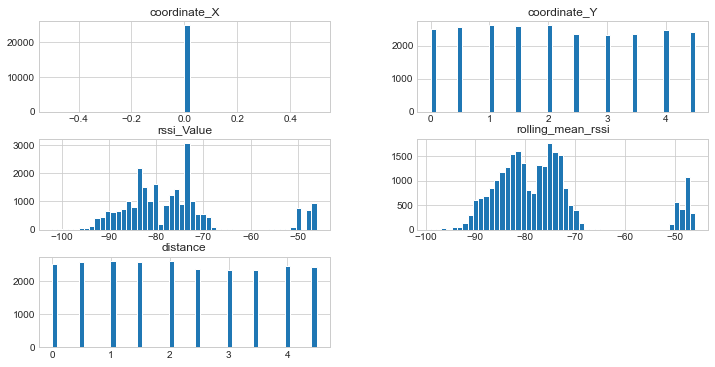

In [13]:
dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Target Attribute - Zone
Graphical display of the zones scanned in the experiment

<AxesSubplot:xlabel='zone'>

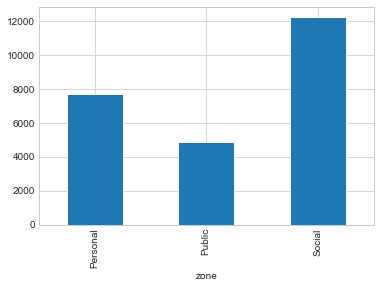

In [14]:
reference_points = dataset.groupby(['zone'])
reference_points.size().plot(kind="bar")

<AxesSubplot:xlabel='zone,distance'>

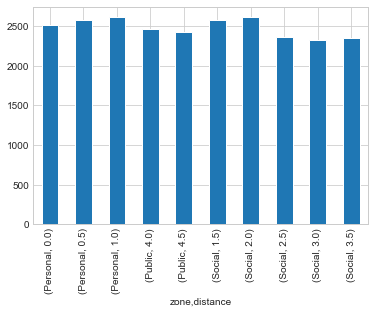

In [15]:
reference_points = dataset.groupby(['zone','distance'])
reference_points.size().plot(kind="bar")

### Beacon RSSI Display
Graphical display of the rssi values recorded at each position

C:\DevelopmentTools\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


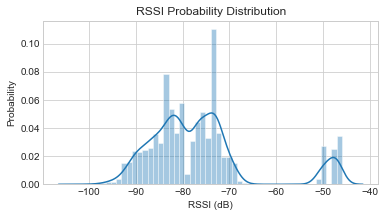

In [16]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')

sns.distplot(dataset['rssi_Value'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Beacon Rolling Mean RSSI Display
Graphical adisplay of the rolling mean value recorded at each position

C:\DevelopmentTools\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


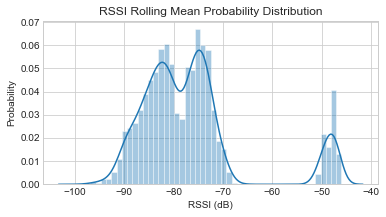

In [17]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Rolling Mean Probability Distribution')
# The KDE plot for the Rolling Mean column
sns.distplot(dataset['rolling_mean_rssi'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Graphical Display of RSSI/Rolling Mean Distribution
Graphical display of the previous measures - rssi and rolling mean

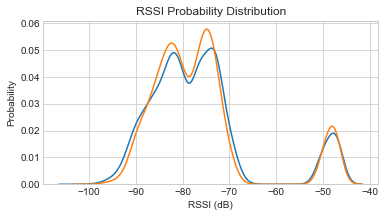

In [18]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(dataset['rssi_Value'], label='RSSI')
# The KDE plot for the Rolling Mean column
sns.kdeplot(dataset['rolling_mean_rssi'], label='Rolling Mean RSSI')
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Correlations
Check how much each attribute collerates with each other. Valures frange from -1 to 1. Close to 1 means a strong positive correlation.

In [19]:
def compute_correlations(dataset):
    corr_matrix = dataset.corr()
    display(corr_matrix)
    display(corr_matrix['distance'].sort_values(ascending=False))
    attributes = ["distance","rssi_Value", "rolling_mean_rssi"]
    scatter_matrix(dataset[attributes], figsize=(12, 8))

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,distance
coordinate_X,NaN,NaN,NaN,NaN,NaN
coordinate_Y,NaN,1.000000,-0.723705,-0.741381,1.000000
rssi_Value,NaN,-0.723705,1.000000,0.958999,-0.723705
rolling_mean_rssi,NaN,-0.741381,0.958999,1.000000,-0.741381
distance,NaN,1.000000,-0.723705,-0.741381,1.000000


coordinate_Y         1.000000
distance             1.000000
rssi_Value          -0.723705
rolling_mean_rssi   -0.741381
coordinate_X              NaN
Name: distance, dtype: float64

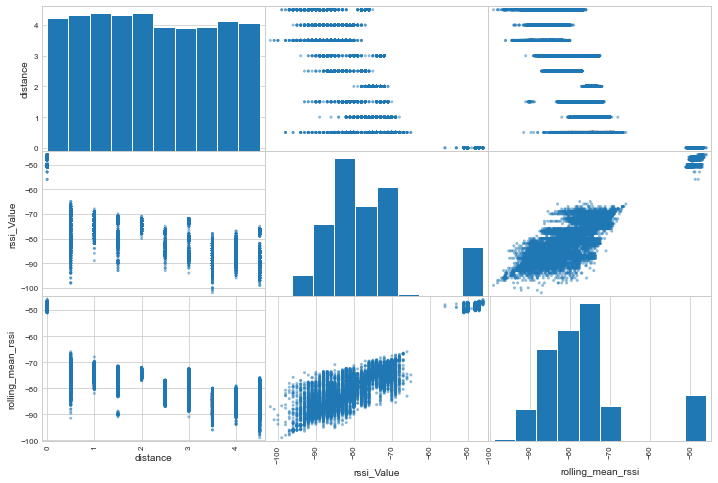

In [20]:
compute_correlations(dataset)

### Data Cleaning
Fill in missing values and fix/remove outliers

In [21]:
def compute_data_cleaning(dataset,feature):
    nan_filler = dataset[feature].min()*1.010
    dataset[feature] = dataset[feature].fillna(nan_filler) # Fill missing values

In [22]:
compute_data_cleaning(dataset,'rssi_Value')
compute_data_cleaning(dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset,'rssi_Value')
compute_data_cleaning(test_dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset_home_big,'rssi_Value')
compute_data_cleaning(test_dataset_home_big,'rolling_mean_rssi')
compute_data_cleaning(test_dataset_home_small,'rssi_Value')
compute_data_cleaning(test_dataset_home_small,'rolling_mean_rssi')
compute_data_cleaning(test_dataset_home_asus,'rssi_Value')
compute_data_cleaning(test_dataset_home_asus,'rolling_mean_rssi')

### Dealing with Categorical Data
Using Hot-Encoder or Label Encoder to convert text/categorical data into numerical data. ML algorithms prefer it

In [23]:
label_encoder = LabelEncoder()
def compute_encoder(categorical_data,flag):
    if flag == 0:
        labels = label_encoder.fit_transform(categorical_data)
    else:
        labels = label_encoder.transform(categorical_data)
    return labels

In [24]:
categorical_zone = dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
zone_changed = compute_encoder(categorical_zone,0)
print("After One Hot Encoder")
dataset['labels'] = zone_changed
train_Y = dataset['labels'].values.reshape(-1,1)
display(train_Y)

Previous Categorical Data


,zone
0,Personal
1,Personal
2,Personal
3,Personal
4,Personal
...,...
24829,Public
24830,Public
24831,Public
24832,Public


After One Hot Encoder


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [25]:
categorical_zone = test_dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset['labels'] = test_changed
test_Y = test_dataset['labels'].values.reshape(-1,1)
display(test_Y.shape)

Previous Categorical Data


,zone
0,Public
1,Public
2,Public
3,Public
4,Public
...,...
3672,Personal
3673,Personal
3674,Personal
3675,Personal


After One Hot Encoder


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(3677, 1)

In [26]:
categorical_zone = test_dataset_home_big[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset_home_big['labels'] = test_changed
test_Y_home_big = test_dataset_home_big['labels'].values.reshape(-1,1)
display(test_Y_home_big.shape)

Previous Categorical Data


,zone
0,Personal
1,Personal
2,Personal
3,Personal
4,Personal
...,...
12470,Social
12471,Social
12472,Social
12473,Social


After One Hot Encoder


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(12475, 1)

In [27]:
categorical_zone = test_dataset_home_small[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset_home_small['labels'] = test_changed
test_Y_home_small = test_dataset_home_small['labels'].values.reshape(-1,1)
display(test_Y_home_small.shape)

Previous Categorical Data


,zone
0,Personal
1,Personal
2,Personal
3,Personal
4,Personal
...,...
2279,Social
2280,Social
2281,Social
2282,Social


After One Hot Encoder


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(2284, 1)

In [28]:
categorical_zone = test_dataset_home_asus[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset_home_asus['labels'] = test_changed
test_Y_home_asus = test_dataset_home_asus['labels'].values.reshape(-1,1)
display(test_Y_home_asus.shape)

Previous Categorical Data


,zone
0,Personal
1,Personal
2,Personal
3,Personal
4,Personal
...,...
410,Social
411,Social
412,Social
413,Social


After One Hot Encoder


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(415, 1)

### Initialize Training Data
Training Data intialization for predictions purposes

In [29]:
train_X_rssi = pd.DataFrame(dataset['rssi_Value']).values.reshape(-1,1)
display(train_X_rssi.shape)
train_X_rolling_mean = pd.DataFrame(dataset['rolling_mean_rssi']).values.reshape(-1,1)
display(train_X_rolling_mean.shape)
combination_features_X = dataset[['rssi_Value','rolling_mean_rssi']]
display(combination_features_X.shape)

(24834, 1)

(24834, 1)

(24834, 2)

In [30]:
data_plot_means = dataset.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
Personal,-66.101350,-66.075278
Public,-84.953374,-84.856790
Social,-80.050008,-80.086162


### Plot Training Data
Graphical Display of the observations in the dataset

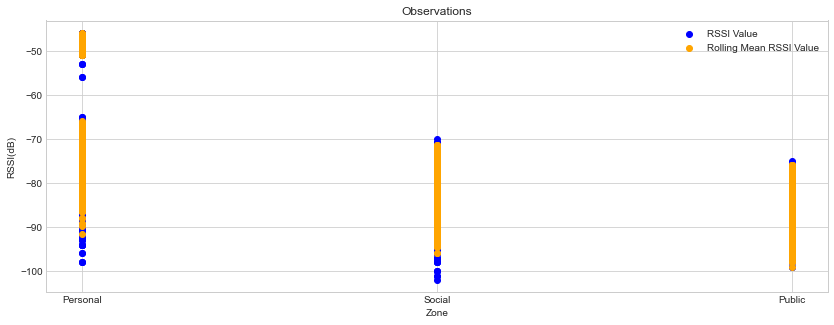

In [31]:
plt.figure(figsize=(14,5))
plt.scatter(dataset['zone'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['zone'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Initialize Test Data

In [32]:
test_X_rssi = pd.DataFrame(test_dataset['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi.shape)
test_X_rolling_mean = pd.DataFrame(test_dataset['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean.shape)
test_combination_features_X = test_dataset[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X.shape)

(3677, 1)

(3677, 1)

(3677, 2)

In [33]:
data_plot_means = test_dataset.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
Personal,-66.634563,-66.593533
Public,-81.438819,-81.521907
Social,-78.235580,-78.069045


In [34]:
test_X_rssi_home_big = pd.DataFrame(test_dataset_home_big['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi_home_big.shape)
test_X_rolling_mean_home_big = pd.DataFrame(test_dataset_home_big['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean_home_big.shape)
test_combination_features_X_home_big = test_dataset_home_big[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X_home_big.shape)

(12475, 1)

(12475, 1)

(12475, 2)

In [35]:
data_plot_means = test_dataset_home_big.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
Personal,-60.626277,-60.688594
Social,-81.402474,-81.424138


In [36]:
test_X_rssi_home_small = pd.DataFrame(test_dataset_home_small['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi_home_small.shape)
test_X_rolling_mean_home_small = pd.DataFrame(test_dataset_home_small['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean_home_small.shape)
test_combination_features_X_home_small = test_dataset_home_small[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X_home_small.shape)

(2284, 1)

(2284, 1)

(2284, 2)

In [37]:
data_plot_means = test_dataset_home_small.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
Personal,-63.987165,-64.275969
Social,-80.535389,-80.579521


In [38]:
test_X_rssi_home_asus = pd.DataFrame(test_dataset_home_asus['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi_home_asus.shape)
test_X_rolling_mean_home_asus = pd.DataFrame(test_dataset_home_asus['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean_home_asus.shape)
test_combination_features_X_home_asus = test_dataset_home_asus[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X_home_asus.shape)

(415, 1)

(415, 1)

(415, 2)

In [39]:
data_plot_means = test_dataset_home_asus.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
Personal,-69.205128,-69.220368
Social,-82.181467,-82.010114


### Plot Test Data

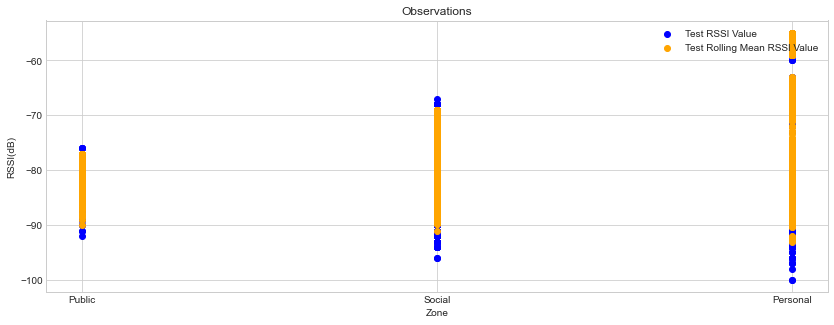

In [40]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset['zone'],test_dataset['rssi_Value'],label='Test RSSI Value',color='blue')
plt.scatter(test_dataset['zone'],test_dataset['rolling_mean_rssi'],label='Test Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

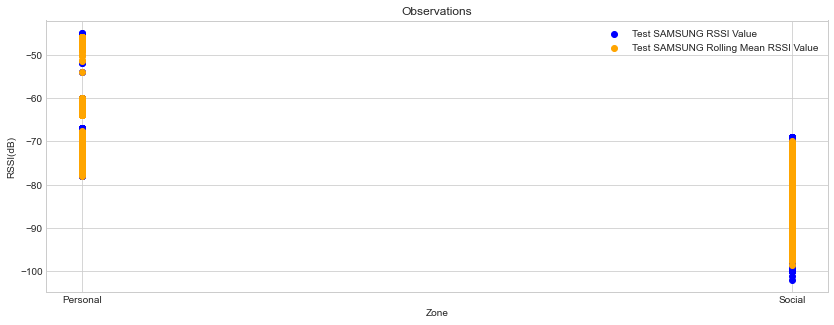

In [41]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset_home_big['zone'],test_dataset_home_big['rssi_Value'],label='Test SAMSUNG RSSI Value',color='blue')
plt.scatter(test_dataset_home_big['zone'],test_dataset_home_big['rolling_mean_rssi'],label='Test SAMSUNG Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

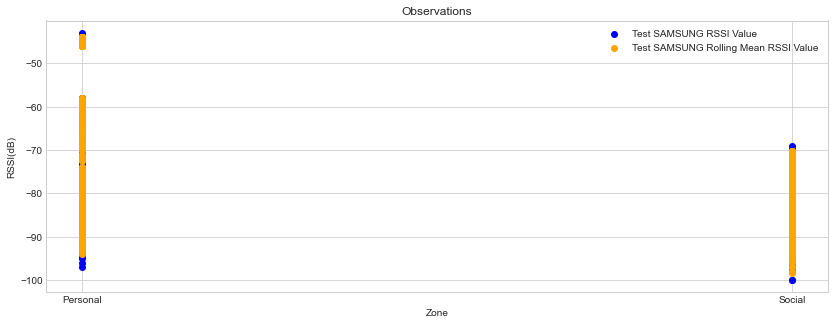

In [42]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset_home_small['zone'],test_dataset_home_small['rssi_Value'],label='Test SAMSUNG RSSI Value',color='blue')
plt.scatter(test_dataset_home_small['zone'],test_dataset_home_small['rolling_mean_rssi'],label='Test SAMSUNG Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

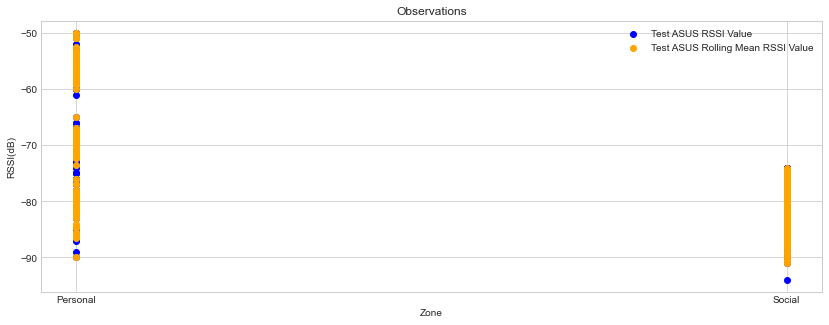

In [43]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset_home_asus['zone'],test_dataset_home_asus['rssi_Value'],label='Test ASUS RSSI Value',color='blue')
plt.scatter(test_dataset_home_asus['zone'],test_dataset_home_asus['rolling_mean_rssi'],label='Test ASUS Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Initialize Hyperparameters for tunning

In [44]:
#Preprocessing options
scaler = [StandardScaler(),MaxAbsScaler(),MinMaxScaler(),None]
# Batch size of samples
batch_size = [10, 20, 40, 60, 80, 100]
# Epochs 
epochs = [10, 50, 100]
# Optimization function
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# Learning Rate - only used with SGD optimizer
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
# Momentum - only used with SGD optimizer
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
# Activation Function
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
# Number of neurons in a hidden layer
neurons = [100,300,400,500,600]

### Statistics Output Format

In [45]:
def structure_data(data,precision,accuracy,f1score, statistics=None):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    precision = precision
    accuracy = accuracy
    f1score = f1score
    statistical_results = [mae,mse,rsme,precision,accuracy,f1score]
    if statistics is not None:
        micro = [statistics.loc['accuracy','precision'], statistics.loc['accuracy','recall'], statistics.loc['accuracy','f1-score']] if 'accuracy' in statistics.index else [statistics.loc['micro avg','precision'],statistics.loc['micro avg','recall'], statistics.loc['micro avg','f1-score']]
        macro = [statistics.loc['macro avg','precision'], statistics.loc['macro avg','recall'], statistics.loc['macro avg','f1-score']]
        weighted = [statistics.loc['weighted avg','precision'], statistics.loc['weighted avg','recall'], statistics.loc['weighted avg','f1-score']]
        return statistical_results + micro + macro + weighted
    else:
        return statistical_results

### Feature Selection
Check strength of features using ensemble algorithm Random Forest

Feature Selection Computation


array([0.38603287, 0.61396713])

rolling_mean_rssi    0.613967
rssi_Value           0.386033
dtype: float64

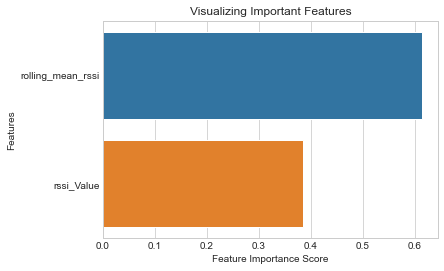

In [46]:
print("Feature Selection Computation")
random_forest_estimator = RandomForestClassifier()
main_estimator = make_pipeline(StandardScaler(),random_forest_estimator)
main_estimator.fit(combination_features_X,train_Y.ravel())
display(random_forest_estimator.feature_importances_)
feature_imp = pd.Series(random_forest_estimator.feature_importances_,index=combination_features_X.columns).sort_values(ascending=False)
display(feature_imp)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Model Training and Evaluation - MLP Classification Model
Experiments with MLP algorithm

In [47]:
num_neurons_basic = 180
print("Default number of neurons: " + str(num_neurons_basic))
# Function to create model, required for KerasClassifier
def create_model(dim=2,num_neurons=num_neurons_basic,activation ='relu',optimizer = 'adam'):
    model = Sequential()
    model.add(Dense(num_neurons,input_dim=dim,activation=activation))
    model.add(Dense(num_neurons,activation=activation))
    model.add(Dense(4,activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    return model
model = create_model()
display(model.summary())

Default number of neurons: 180
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 180)               540       
_________________________________________________________________
dense_1 (Dense)              (None, 180)               32580     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 724       
Total params: 33,844
Trainable params: 33,844
Non-trainable params: 0
_________________________________________________________________


None

In [48]:
def compute_MLP_Classifier(flag=0,dim=2,
                              trainX_data = None, trainY_data = None,
                              testX_data = None,testY_data = None, 
                              scaler = None,cross_validation = None,batch_size=10,epochs=50,verbose=0,num_neurons_param=180,optimizer_func='adam',activation_func='relu'):
    keras_classification_model = KerasClassifier(build_fn=create_model,dim=dim,epochs=epochs,num_neurons=num_neurons_param,optimizer=optimizer_func,activation=activation_func,batch_size=batch_size,verbose=verbose)
    seed = 7
    np.random.seed(seed)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,keras_classification_model)
    else:
        main_estimator = keras_classification_model
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data)
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    else:
        print("Cross Validation Activated. CV = " + str(cross_validation))
        predict_test = cross_val_predict(main_estimator,testX_data,testY_data,cv = cross_validation)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    statistical_array = list()
    statistics = pd.DataFrame(report).transpose()
    error_dataframe = pd.DataFrame({'Actual': testY_data.flatten(), 'Predicted':predict_test.flatten()})
    if flag == 1:
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
    error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
    result = pd.DataFrame(dataset.zone,columns=["zone"]).join(error)
    return structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean(),statistics)

### Best Parameters
Display the best parameters tunned throughout the experiments

In [49]:
conclusion_cols=['Cross_Validation','Number of Neurons','Activation Function','Batch Size','Epochs','Optimizer','Learning Rate',
                 'Momentum','Preprocessing']

selected_method = 'HoldOut'
selected_number_neurons = 300
selected_activation_function = 'sigmoid'
selected_batch_size = 10
selected_epochs = 10
selected_optimization_algorithm = 'Adamax'
selected_learning_rate = 0.01
selected_momentum = 0.2
selected_preprocessing = 'StandardScaler'

conclusion_list = [selected_method,selected_number_neurons,selected_activation_function,selected_batch_size,selected_epochs,
                   selected_optimization_algorithm,selected_learning_rate,selected_momentum,selected_preprocessing]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)

,Cross_Validation,Number of Neurons,Activation Function,Batch Size,Epochs,Optimizer,Learning Rate,Momentum,Preprocessing
0,HoldOut,300,sigmoid,10,10,Adamax,0.01,0.2,StandardScaler


### Best Results
Compute MLP with the best parameters

In [50]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score',
                    'micro precision', 'micro recall', 'micro f1-score',
                    'macro precision', 'macro recall', 'macro f1-score',
                    'weighted precision', 'weighted recall', 'weighted f1-score',
                    'type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
final_results = list()
dim = 2
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
        loo = compute_MLP_Classifier(testX_data=trainX_data,dim=dim,epochs=selected_epochs,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                    num_neurons_param=selected_number_neurons,activation_func=selected_activation_function,
                                    batch_size=selected_batch_size,optimizer_func=selected_optimization_algorithm) 
    elif selected_method =='Stratified K-Fold':
        result = compute_MLP_Classifier(testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = 5,
                                    num_neurons_param=selected_number_neurons,activation_func=selected_activation_function,
                                    batch_size=selected_batch_size,optimizer_func=selected_optimization_algorithm)   
    else:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
        result = compute_MLP_Classifier(dim=dim,epochs=25,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler(),
                                    num_neurons_param=selected_number_neurons,activation_func=selected_activation_function,
                                    batch_size=selected_batch_size,optimizer_func=selected_optimization_algorithm) 
    result.append(scannedType)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending = False))
final_results.append(statistics.sort_values(by=['f1-score'],ascending=False).head(1).values[0])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


,mae,mse,rmse,precision,accuracy,f1-score,micro precision,micro recall,micro f1-score,macro precision,macro recall,macro f1-score,weighted precision,weighted recall,weighted f1-score,type
0,0.317675,0.317675,0.563627,0.739158,0.682325,0.633758,0.682325,0.682325,0.682325,0.752960,0.587338,0.614814,0.740784,0.682325,0.660968,RSSI Only
1,0.335660,0.335660,0.579361,0.705902,0.664340,0.623655,0.664340,0.664340,0.664340,0.715886,0.581195,0.607510,0.707524,0.664340,0.647551,Rolling Mean RSSI
2,0.342639,0.342639,0.585353,0.703211,0.657361,0.594611,0.657361,0.657361,0.657361,0.714936,0.552675,0.570798,0.702159,0.657361,0.627112,Both


### Best Results - Testing data (Different Beacon)
Experiment with testing dataset

In [51]:
num_neurons_basic = 180
print("Default number of neurons: " + str(num_neurons_basic))
# Function to create model, required for KerasClassifier
def create_model_test(dim=2,num_neurons=num_neurons_basic,activation ='relu',optimizer = 'adam'):
    model = Sequential()
    model.add(Dense(num_neurons,input_dim=dim,activation=activation))
    model.add(Dense(num_neurons,activation=activation))
    model.add(Dense(4,activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    return model
model = create_model_test()
display(model.summary())

Default number of neurons: 180
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 180)               540       
_________________________________________________________________
dense_13 (Dense)             (None, 180)               32580     
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 724       
Total params: 33,844
Trainable params: 33,844
Non-trainable params: 0
_________________________________________________________________


None

Confusion Matrix:
[[ 986   69   56]
 [   0    7  704]
 [ 304   79 1472]]


,precision,recall,f1-score,support
0,0.764341,0.887489,0.821324,1111.000000
1,0.045161,0.009845,0.016166,711.000000
2,0.659498,0.793531,0.720333,1855.000000
accuracy,0.670383,0.670383,0.670383,0.670383
macro avg,0.489667,0.563622,0.519274,3677.000000
weighted avg,0.572386,0.670383,0.614687,3677.000000


,Actual,Predicted
0,1,2
1,1,2
2,1,2
3,1,2
4,1,1
...,...,...
3672,0,0
3673,0,0
3674,0,0
3675,0,0


777/777 [==============================] - 1s 965us/step - loss: 1.0450 - accuracy: 0.4894
Confusion Matrix:
[[   0  114  997]
 [   0  555  156]
 [   0  614 1241]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,1111.000000
1,0.432580,0.780591,0.556670,711.000000
2,0.518379,0.669003,0.584137,1855.000000
accuracy,0.488442,0.488442,0.488442,0.488442
macro avg,0.316986,0.483198,0.380269,3677.000000
weighted avg,0.345161,0.488442,0.402330,3677.000000


,Actual,Predicted
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
3672,0,2
3673,0,2
3674,0,2
3675,0,2


Confusion Matrix:
[[ 941   33  137]
 [   0    3  708]
 [ 119   51 1685]]


,precision,recall,f1-score,support
0,0.887736,0.846985,0.866882,1111.000000
1,0.034483,0.004219,0.007519,711.000000
2,0.666008,0.908356,0.768529,1855.000000
accuracy,0.714985,0.714985,0.714985,0.714985
macro avg,0.529409,0.586520,0.547643,3677.000000
weighted avg,0.610888,0.714985,0.651094,3677.000000


,Actual,Predicted
0,1,2
1,1,2
2,1,2
3,1,2
4,1,2
...,...,...
3672,0,0
3673,0,0
3674,0,0
3675,0,0


777/777 [==============================] - 1s 965us/step - loss: 1.0425 - accuracy: 0.4844
Confusion Matrix:
[[   0    0 1111]
 [   0    0  711]
 [   0    0 1855]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,1111.000000
1,0.000000,0.000000,0.000000,711.000000
2,0.504487,1.000000,0.670644,1855.000000
accuracy,0.504487,0.504487,0.504487,0.504487
macro avg,0.168162,0.333333,0.223548,3677.000000
weighted avg,0.254507,0.504487,0.338331,3677.000000


,Actual,Predicted
0,1,2
1,1,2
2,1,2
3,1,2
4,1,2
...,...,...
3672,0,2
3673,0,2
3674,0,2
3675,0,2


Confusion Matrix:
[[ 958   62   91]
 [  12   11  688]
 [ 458   59 1338]]


,precision,recall,f1-score,support
0,0.670868,0.862286,0.754628,1111.000000
1,0.083333,0.015471,0.026097,711.000000
2,0.632026,0.721294,0.673716,1855.000000
accuracy,0.627414,0.627414,0.627414,0.627414
macro avg,0.462076,0.533017,0.484814,3677.000000
weighted avg,0.537665,0.627414,0.572937,3677.000000


,Actual,Predicted
0,1,2
1,1,2
2,1,2
3,1,2
4,1,1
...,...,...
3672,0,0
3673,0,0
3674,0,0
3675,0,0


777/777 [==============================] - 1s 976us/step - loss: 1.0429 - accuracy: 0.4828
Confusion Matrix:
[[ 100   16  995]
 [ 188  248  275]
 [ 309  209 1337]]


,precision,recall,f1-score,support
0,0.167504,0.090009,0.117096,1111.000000
1,0.524313,0.348805,0.418919,711.000000
2,0.512850,0.720755,0.599283,1855.000000
accuracy,0.458254,0.458254,0.458254,0.458254
macro avg,0.401556,0.386523,0.378433,3677.000000
weighted avg,0.410721,0.458254,0.418715,3677.000000


,Actual,Predicted
0,1,0
1,1,0
2,1,1
3,1,0
4,1,0
...,...,...
3672,0,2
3673,0,2
3674,0,2
3675,0,2


,mae,mse,rmse,precision,accuracy,f1-score,micro precision,micro recall,micro f1-score,macro precision,macro recall,macro f1-score,weighted precision,weighted recall,weighted f1-score,type,Tuning
2,0.285015,0.285015,0.533868,0.573918,0.714985,0.592775,0.714985,0.714985,0.714985,0.529409,0.586520,0.547643,0.610888,0.714985,0.651094,Rolling Mean RSSI,True
0,0.329617,0.329617,0.574122,0.533573,0.670383,0.560361,0.670383,0.670383,0.670383,0.489667,0.563622,0.519274,0.572386,0.670383,0.614687,RSSI Only,True
4,0.372586,0.372586,0.610399,0.502230,0.627414,0.523268,0.627414,0.627414,0.627414,0.462076,0.533017,0.484814,0.537665,0.627414,0.572937,Both,True
1,0.511558,0.511558,0.715233,0.350258,0.488442,0.401975,0.488442,0.488442,0.488442,0.316986,0.483198,0.380269,0.345161,0.488442,0.402330,RSSI Only,False
5,0.541746,0.541746,0.736034,0.412533,0.458254,0.398450,0.458254,0.458254,0.458254,0.401556,0.386523,0.378433,0.410721,0.458254,0.418715,Both,False
3,0.495513,0.495513,0.703927,0.238607,0.504487,0.289502,0.504487,0.504487,0.504487,0.168162,0.333333,0.223548,0.254507,0.504487,0.338331,Rolling Mean RSSI,False


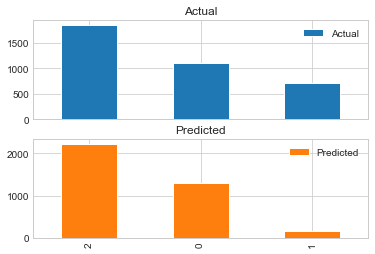

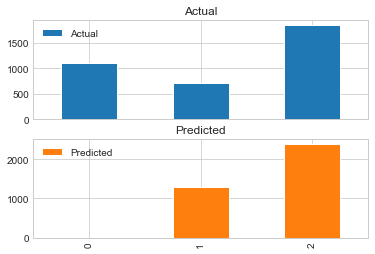

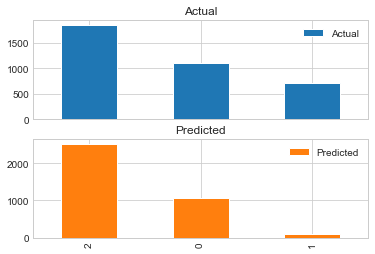

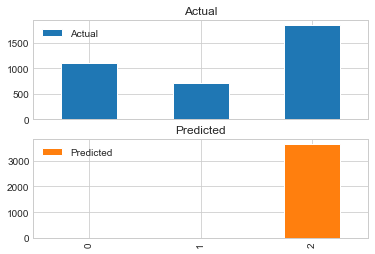

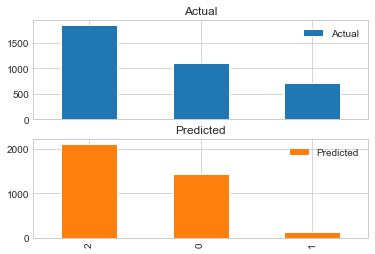

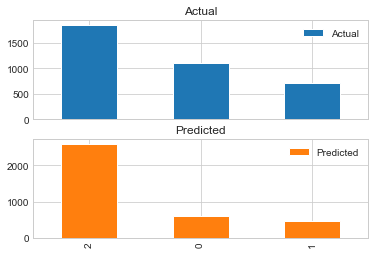

In [52]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score',
                    'micro precision', 'micro recall', 'micro f1-score',
                    'macro precision', 'macro recall', 'macro f1-score',
                    'weighted precision', 'weighted recall', 'weighted f1-score',
                    'type','Tuning']
results = list()
tuning =[True,False]
types = ['RSSI Only','Rolling Mean RSSI','Both']
dim = 2
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X 
        dim = 2
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    seed = 7
    np.random.seed(seed)
    for tune in tuning:
        if tune == True:
            keras_classification_model = KerasClassifier(build_fn=create_model,dim=dim,epochs=50,
                                                             num_neurons=selected_number_neurons,
                                                             optimizer=selected_optimization_algorithm,
                                                             activation=selected_activation_function,
                                                             batch_size=10,verbose=0)
        else: 
            keras_classification_model = KerasClassifier(build_fn=create_model,dim=dim)
        trainX_data = scaler.transform(trainX_data)
        keras_classification_model.fit(trainX_data,train_Y)
        predicted = keras_classification_model.predict(testX_data)
        matrix = confusion_matrix(test_Y.ravel(), predicted)
        report = classification_report(test_Y.ravel(), predicted,output_dict=True)
        accuracy = accuracy_score(test_Y.ravel(),predicted)
        statistical_array = list()
        statistics = pd.DataFrame(report).transpose()
        error_dataframe = pd.DataFrame({'Actual': test_Y.flatten(), 'Predicted':predicted.flatten()})
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
        result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
        data = structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean(),statistics)
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
final_results.append(statistics.sort_values(by=['f1-score'],ascending=False).head(1).values[0])

### Best Results - Home Testing data (using data recovered from Android 10 SAMSUNG Galaxy A71 BIG Dataset)
Experiment with testing dataset

Confusion Matrix:
[[4108    0  687]
 [   0    0    0]
 [1350  977 5353]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.752657,0.856726,0.801326,4795.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.886258,0.697005,0.780321,7680.000000
accuracy,0.758397,0.758397,0.758397,0.758397
macro avg,0.546305,0.517910,0.527216,12475.000000
weighted avg,0.834906,0.758397,0.788395,12475.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12470,2,2
12471,2,2
12472,2,2
12473,2,2


777/777 [==============================] - 1s 896us/step - loss: 1.0430 - accuracy: 0.4879
Confusion Matrix:
[[   0 4795]
 [   0 7680]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,4795.000000
2,0.615631,1.000000,0.762094,7680.000000
accuracy,0.615631,0.615631,0.615631,0.615631
macro avg,0.307816,0.500000,0.381047,12475.000000
weighted avg,0.379002,0.615631,0.469169,12475.000000


,Actual,Predicted
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
12470,2,2
12471,2,2
12472,2,2
12473,2,2


Confusion Matrix:
[[4067    0  728]
 [   0    0    0]
 [ 731 1303 5646]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.847645,0.848175,0.847910,4795.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.885786,0.735156,0.803472,7680.000000
accuracy,0.778597,0.778597,0.778597,0.778597
macro avg,0.577810,0.527777,0.550461,12475.000000
weighted avg,0.871126,0.778597,0.820553,12475.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12470,2,2
12471,2,2
12472,2,2
12473,2,2


777/777 [==============================] - 1s 1ms/step - loss: 1.0416 - accuracy: 0.4901
Confusion Matrix:
[[   0    0 4795]
 [   0    0    0]
 [  97 4771 2812]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,4795.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.369660,0.366146,0.367894,7680.000000
accuracy,0.225411,0.225411,0.225411,0.225411
macro avg,0.123220,0.122049,0.122631,12475.000000
weighted avg,0.227574,0.225411,0.226487,12475.000000


,Actual,Predicted
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
12470,2,1
12471,2,1
12472,2,1
12473,2,1


Confusion Matrix:
[[3797    0  998]
 [   0    0    0]
 [ 313 1259 6108]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.923844,0.791867,0.852779,4795.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.859555,0.795312,0.826187,7680.000000
accuracy,0.793988,0.793988,0.793988,0.793988
macro avg,0.594467,0.529060,0.559655,12475.000000
weighted avg,0.884266,0.793988,0.836408,12475.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12470,2,2
12471,2,2
12472,2,2
12473,2,2


777/777 [==============================] - 1s 947us/step - loss: 1.0434 - accuracy: 0.4874
Confusion Matrix:
[[   0   14 4781]
 [   0    0    0]
 [ 592   72 7016]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,4795.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.594727,0.913542,0.720439,7680.000000
accuracy,0.562405,0.562405,0.562405,0.562405
macro avg,0.198242,0.304514,0.240146,12475.000000
weighted avg,0.366133,0.562405,0.443525,12475.000000


,Actual,Predicted
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
12470,2,2
12471,2,2
12472,2,2
12473,2,2


,mae,mse,rmse,precision,accuracy,f1-score,micro precision,micro recall,micro f1-score,macro precision,macro recall,macro f1-score,weighted precision,weighted recall,weighted f1-score,type,Tuning
4,0.206012,0.206012,0.453885,0.676020,0.793988,0.644836,0.793988,0.793988,0.793988,0.594467,0.529060,0.559655,0.884266,0.793988,0.836408,Both,True
2,0.221403,0.221403,0.470535,0.660161,0.778597,0.633499,0.778597,0.778597,0.778597,0.577810,0.527777,0.550461,0.871126,0.778597,0.820553,Rolling Mean RSSI,True
0,0.241603,0.241603,0.491531,0.629754,0.758397,0.609276,0.758397,0.758397,0.758397,0.546305,0.517910,0.527216,0.834906,0.758397,0.788395,RSSI Only,True
1,0.384369,0.384369,0.619975,0.383616,0.615631,0.445588,0.615631,0.615631,0.615631,0.307816,0.500000,0.381047,0.379002,0.615631,0.469169,RSSI Only,False
5,0.437595,0.437595,0.661510,0.286918,0.562405,0.327753,0.562405,0.562405,0.562405,0.198242,0.304514,0.240146,0.366133,0.562405,0.443525,Both,False
3,0.774589,0.774589,0.880107,0.157644,0.225411,0.157071,0.225411,0.225411,0.225411,0.123220,0.122049,0.122631,0.227574,0.225411,0.226487,Rolling Mean RSSI,False


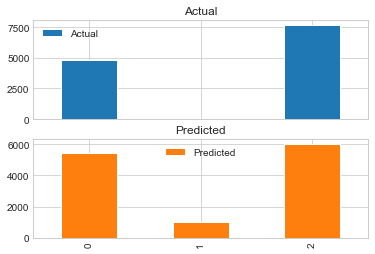

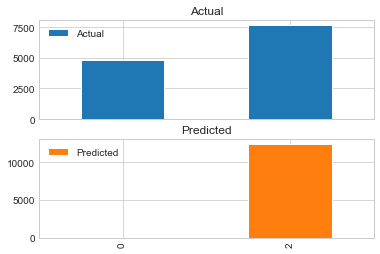

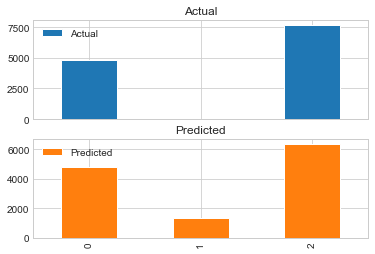

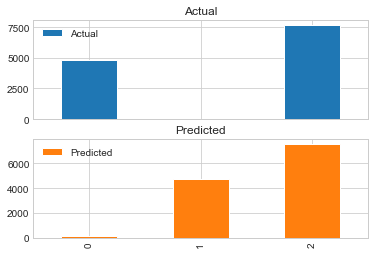

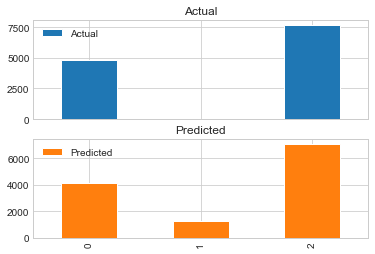

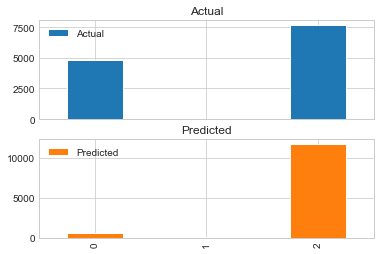

In [53]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score',
                    'micro precision', 'micro recall', 'micro f1-score',
                    'macro precision', 'macro recall', 'macro f1-score',
                    'weighted precision', 'weighted recall', 'weighted f1-score',
                    'type','Tuning']
results = list()
tuning =[True,False]
dim = 2
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi_home_big
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean_home_big
        dim = 1
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X_home_big
        dim = 2
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    seed = 7
    np.random.seed(seed)
    for tune in tuning:
        if tune == True:
            keras_classification_model = KerasClassifier(build_fn=create_model,dim=dim,
                                                        num_neurons=selected_number_neurons,activation=selected_activation_function,
                                        batch_size=10,epochs=50,optimizer=selected_optimization_algorithm,verbose=0)  
        else: 
            keras_classification_model = KerasClassifier(build_fn=create_model,dim=dim)
        trainX_data = scaler.transform(trainX_data)
        keras_classification_model.fit(trainX_data,train_Y.ravel())
        predicted = keras_classification_model.predict(testX_data)
        matrix = confusion_matrix(test_Y_home_big.ravel(), predicted)
        report = classification_report(test_Y_home_big.ravel(), predicted,output_dict=True)
        accuracy = accuracy_score(test_Y_home_big.ravel(),predicted)
        statistical_array = list()
        statistics = pd.DataFrame(report).transpose()
        error_dataframe = pd.DataFrame({'Actual': test_Y_home_big.flatten(), 'Predicted':predicted.flatten()})
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
        result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
        data = structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean(),statistics)
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
final_results.append(statistics.sort_values(by=['f1-score'],ascending=False).head(1).values[0])

### Best Results - Home Testing data (using data recovered from Android 10 SAMSUNG Galaxy A71 Small Dataset)
Experiment with testing dataset

Confusion Matrix:
[[ 508   69  280]
 [   0    0    0]
 [ 121  241 1065]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.807631,0.592765,0.683715,857.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.791822,0.746321,0.768398,1427.000000
accuracy,0.688704,0.688704,0.688704,0.688704
macro avg,0.533151,0.446362,0.484038,2284.000000
weighted avg,0.797754,0.688704,0.736623,2284.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2279,2,2
2280,2,2
2281,2,2
2282,2,1


777/777 [==============================] - 1s 965us/step - loss: 1.0435 - accuracy: 0.4878
Confusion Matrix:
[[   0   95  762]
 [   0    0    0]
 [   0  405 1022]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,857.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.572870,0.716188,0.636562,1427.000000
accuracy,0.447461,0.447461,0.447461,0.447461
macro avg,0.190957,0.238729,0.212187,2284.000000
weighted avg,0.357918,0.447461,0.397712,2284.000000


,Actual,Predicted
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
2279,2,1
2280,2,1
2281,2,1
2282,2,1


Confusion Matrix:
[[ 507   27  323]
 [   0    0    0]
 [  88  138 1201]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.852101,0.591599,0.698347,857.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.788058,0.841626,0.813961,1427.000000
accuracy,0.747811,0.747811,0.747811,0.747811
macro avg,0.546720,0.477741,0.504103,2284.000000
weighted avg,0.812088,0.747811,0.770581,2284.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2279,2,2
2280,2,2
2281,2,2
2282,2,2


777/777 [==============================] - 1s 889us/step - loss: 1.0429 - accuracy: 0.4894
Confusion Matrix:
[[  0 158 699]
 [  0   0   0]
 [  0 632 795]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,857.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.532129,0.557113,0.544334,1427.000000
accuracy,0.348074,0.348074,0.348074,0.348074
macro avg,0.177376,0.185704,0.181445,2284.000000
weighted avg,0.332464,0.348074,0.340090,2284.000000


,Actual,Predicted
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
2279,2,1
2280,2,1
2281,2,1
2282,2,1


Confusion Matrix:
[[ 497   19  341]
 [   0    0    0]
 [  55  102 1270]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.900362,0.579930,0.705465,857.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.788330,0.889979,0.836076,1427.000000
accuracy,0.773643,0.773643,0.773643,0.773643
macro avg,0.562898,0.489970,0.513847,2284.000000
weighted avg,0.830367,0.773643,0.787068,2284.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2279,2,2
2280,2,2
2281,2,2
2282,2,2


777/777 [==============================] - 1s 1ms/step - loss: 1.0486 - accuracy: 0.4878
Confusion Matrix:
[[  0 242 615]
 [  0   0   0]
 [  0 812 615]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,857.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.500000,0.430974,0.462928,1427.000000
accuracy,0.269264,0.269264,0.269264,0.269264
macro avg,0.166667,0.143658,0.154309,2284.000000
weighted avg,0.312391,0.269264,0.289229,2284.000000


,Actual,Predicted
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
2279,2,1
2280,2,1
2281,2,1
2282,2,1


,mae,mse,rmse,precision,accuracy,f1-score,micro precision,micro recall,micro f1-score,macro precision,macro recall,macro f1-score,weighted precision,weighted recall,weighted f1-score,type,Tuning
4,0.226357,0.226357,0.475770,0.642600,0.773643,0.602683,0.773643,0.773643,0.773643,0.562898,0.489970,0.513847,0.830367,0.773643,0.787068,Both,True
2,0.252189,0.252189,0.502184,0.624463,0.747811,0.589134,0.747811,0.747811,0.747811,0.546720,0.477741,0.504103,0.812088,0.747811,0.770581,Rolling Mean RSSI,True
0,0.311296,0.311296,0.557939,0.603177,0.688704,0.560246,0.688704,0.688704,0.688704,0.533151,0.446362,0.484038,0.797754,0.688704,0.736623,RSSI Only,True
1,0.552539,0.552539,0.743330,0.261534,0.447461,0.282320,0.447461,0.447461,0.447461,0.190957,0.238729,0.212187,0.357918,0.447461,0.397712,RSSI Only,False
3,0.651926,0.651926,0.807420,0.231674,0.348074,0.235657,0.348074,0.348074,0.348074,0.177376,0.185704,0.181445,0.332464,0.348074,0.340090,Rolling Mean RSSI,False
5,0.730736,0.730736,0.854831,0.208054,0.269264,0.195955,0.269264,0.269264,0.269264,0.166667,0.143658,0.154309,0.312391,0.269264,0.289229,Both,False


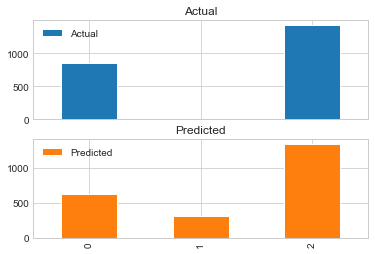

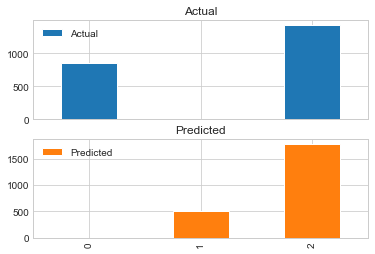

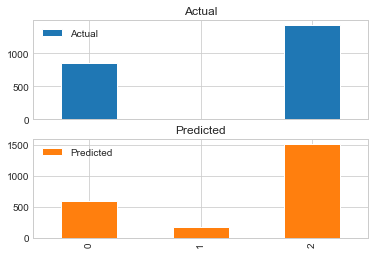

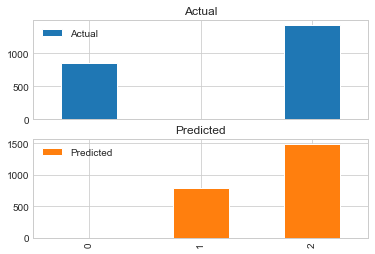

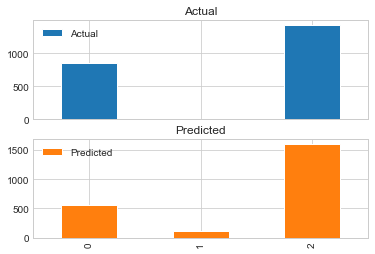

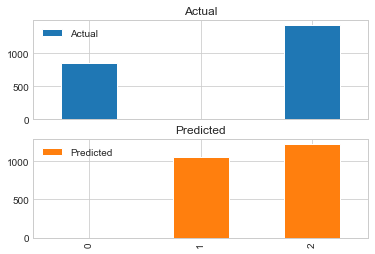

In [54]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score',
                    'micro precision', 'micro recall', 'micro f1-score',
                    'macro precision', 'macro recall', 'macro f1-score',
                    'weighted precision', 'weighted recall', 'weighted f1-score',
                    'type','Tuning']
results = list()
tuning =[True,False]
dim = 2
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi_home_small
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean_home_small
        dim = 1
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X_home_small
        dim = 2
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    seed = 7
    np.random.seed(seed)
    for tune in tuning:
        if tune == True:
            keras_classification_model = KerasClassifier(build_fn=create_model,dim=dim,
                                                        num_neurons=selected_number_neurons,activation=selected_activation_function,
                                        batch_size=10,epochs=50,optimizer=selected_optimization_algorithm,verbose=0)   
        else: 
            keras_classification_model = KerasClassifier(build_fn=create_model,dim=dim)
        trainX_data = scaler.transform(trainX_data)
        keras_classification_model.fit(trainX_data,train_Y.ravel())
        predicted = keras_classification_model.predict(testX_data)
        matrix = confusion_matrix(test_Y_home_small.ravel(), predicted)
        report = classification_report(test_Y_home_small.ravel(), predicted,output_dict=True)
        accuracy = accuracy_score(test_Y_home_small.ravel(),predicted)
        statistical_array = list()
        statistics = pd.DataFrame(report).transpose()
        error_dataframe = pd.DataFrame({'Actual': test_Y_home_small.flatten(), 'Predicted':predicted.flatten()})
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
        result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
        data = structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean(),statistics)
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
final_results.append(statistics.sort_values(by=['f1-score'],ascending=False).head(1).values[0])

### Best Results - Home Testing data (using data recovered from ASUS ZENFONE LIVE)
Experiment with testing dataset

Confusion Matrix:
[[ 94   2  60]
 [  0   0   0]
 [ 22  23 214]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.810345,0.602564,0.691176,156.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.781022,0.826255,0.803002,259.000000
accuracy,0.742169,0.742169,0.742169,0.742169
macro avg,0.530456,0.476273,0.498059,415.000000
weighted avg,0.792044,0.742169,0.760966,415.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
410,2,2
411,2,1
412,2,2
413,2,2


777/777 [==============================] - 1s 1ms/step - loss: 1.0439 - accuracy: 0.4846
Confusion Matrix:
[[  0 156]
 [  0 259]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,156.000000
2,0.624096,1.000000,0.768546,259.000000
accuracy,0.624096,0.624096,0.624096,0.624096
macro avg,0.312048,0.500000,0.384273,415.000000
weighted avg,0.389496,0.624096,0.479647,415.000000


,Actual,Predicted
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
410,2,2
411,2,2
412,2,2
413,2,2


Confusion Matrix:
[[100   1  55]
 [  0   0   0]
 [  2  12 245]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.980392,0.641026,0.775194,156.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.816667,0.945946,0.876565,259.000000
accuracy,0.831325,0.831325,0.831325,0.831325
macro avg,0.599020,0.528991,0.550586,415.000000
weighted avg,0.878212,0.831325,0.838459,415.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
410,2,2
411,2,2
412,2,2
413,2,2


777/777 [==============================] - 1s 961us/step - loss: 1.0427 - accuracy: 0.4888
Confusion Matrix:
[[  0  12 144]
 [  0   0   0]
 [  0 121 138]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,156.00000
1,0.000000,0.000000,0.000000,0.00000
2,0.489362,0.532819,0.510166,259.00000
accuracy,0.332530,0.332530,0.332530,0.33253
macro avg,0.163121,0.177606,0.170055,415.00000
weighted avg,0.305409,0.332530,0.318393,415.00000


,Actual,Predicted
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
410,2,1
411,2,1
412,2,1
413,2,1


Confusion Matrix:
[[106   4  46]
 [  0   0   0]
 [ 22  37 200]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.828125,0.679487,0.746479,156.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.813008,0.772201,0.792079,259.000000
accuracy,0.737349,0.737349,0.737349,0.737349
macro avg,0.547044,0.483896,0.512853,415.000000
weighted avg,0.818691,0.737349,0.774938,415.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
410,2,2
411,2,2
412,2,2
413,2,2


777/777 [==============================] - 1s 1ms/step - loss: 1.0463 - accuracy: 0.4813
Confusion Matrix:
[[  0  19 137]
 [  0   0   0]
 [  0  41 218]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,156.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.614085,0.841699,0.710098,259.000000
accuracy,0.525301,0.525301,0.525301,0.525301
macro avg,0.204695,0.280566,0.236699,415.000000
weighted avg,0.383248,0.525301,0.443169,415.000000


,Actual,Predicted
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
410,2,2
411,2,2
412,2,2
413,2,2


,mae,mse,rmse,precision,accuracy,f1-score,micro precision,micro recall,micro f1-score,macro precision,macro recall,macro f1-score,weighted precision,weighted recall,weighted f1-score,type,Tuning
2,0.168675,0.168675,0.410700,0.684269,0.831325,0.645355,0.831325,0.831325,0.831325,0.599020,0.528991,0.550586,0.878212,0.831325,0.838459,Rolling Mean RSSI,True
4,0.262651,0.262651,0.512494,0.624036,0.737349,0.593950,0.737349,0.737349,0.737349,0.547044,0.483896,0.512853,0.818691,0.737349,0.774938,Both,True
0,0.257831,0.257831,0.507771,0.609339,0.742169,0.582562,0.742169,0.742169,0.742169,0.530456,0.476273,0.498059,0.792044,0.742169,0.760966,RSSI Only,True
1,0.375904,0.375904,0.613110,0.389947,0.624096,0.451312,0.624096,0.624096,0.624096,0.312048,0.500000,0.384273,0.389496,0.624096,0.479647,RSSI Only,False
5,0.474699,0.474699,0.688984,0.287888,0.525301,0.319211,0.525301,0.525301,0.525301,0.204695,0.280566,0.236699,0.383248,0.525301,0.443169,Both,False
3,0.667470,0.667470,0.816988,0.215070,0.332530,0.221857,0.332530,0.332530,0.332530,0.163121,0.177606,0.170055,0.305409,0.332530,0.318393,Rolling Mean RSSI,False


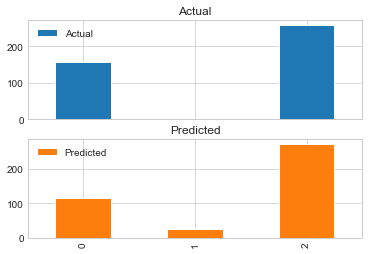

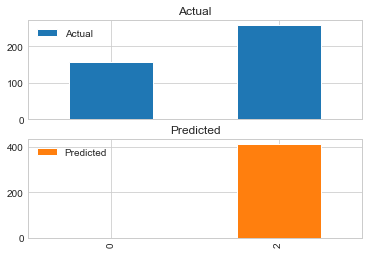

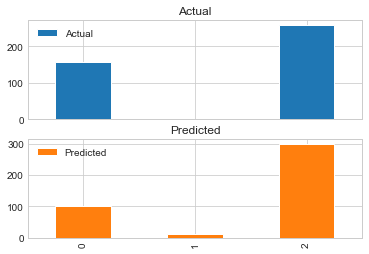

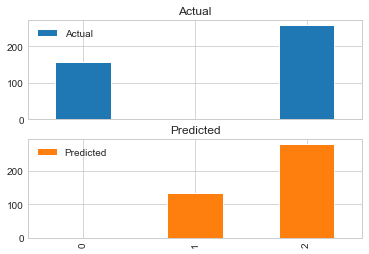

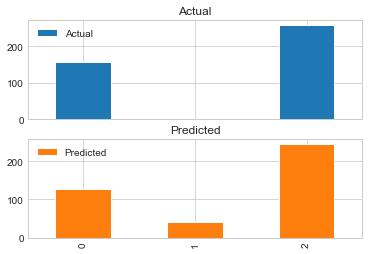

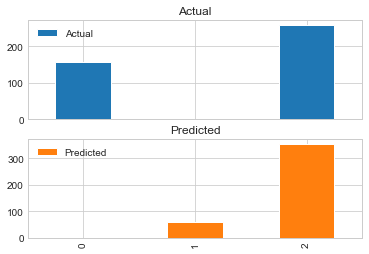

In [55]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score',
                    'micro precision', 'micro recall', 'micro f1-score',
                    'macro precision', 'macro recall', 'macro f1-score',
                    'weighted precision', 'weighted recall', 'weighted f1-score',
                    'type','Tuning']
results = list()
tuning =[True,False]
dim = 2
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi_home_asus
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean_home_asus
        dim = 1
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X_home_asus
        dim = 2
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    seed = 7
    np.random.seed(seed)
    for tune in tuning:
        if tune == True:
            keras_classification_model = KerasClassifier(build_fn=create_model,dim=dim,
                                                        num_neurons=selected_number_neurons,activation=selected_activation_function,
                                        batch_size=10,epochs=50,optimizer=selected_optimization_algorithm,verbose=0)  
        else: 
            keras_classification_model = KerasClassifier(build_fn=create_model,dim=dim)
        trainX_data = scaler.transform(trainX_data)
        keras_classification_model.fit(trainX_data,train_Y.ravel())
        predicted = keras_classification_model.predict(testX_data)
        matrix = confusion_matrix(test_Y_home_asus.ravel(), predicted)
        report = classification_report(test_Y_home_asus.ravel(), predicted,output_dict=True)
        accuracy = accuracy_score(test_Y_home_asus.ravel(),predicted)
        statistical_array = list()
        statistics = pd.DataFrame(report).transpose()
        error_dataframe = pd.DataFrame({'Actual': test_Y_home_asus.flatten(), 'Predicted':predicted.flatten()})
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
        result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
        data = structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean(),statistics)
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
final_results.append(statistics.sort_values(by=['f1-score'],ascending=False).head(1).values[0])

### Results Display

In [56]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score',
                    'micro precision', 'micro recall', 'micro f1-score',
                    'macro precision', 'macro recall', 'macro f1-score',
                    'weighted precision', 'weighted recall', 'weighted f1-score',
                    'type','Tuning']
types = ['University Training Dataset Score','Different Beacon Score','Different Environment Score','Different Environment Score Small dataset',
        "Different Smartphone used for scanning"]
final_results.pop(1)
results = pd.DataFrame(data=final_results,columns=statistical_cols)
display(results.sort_values(by=['f1-score'],ascending=False))
# plt.figure(figsize=(20,5))
# plt.plot(types,results['f1-score'],color='green',label='Score Line')
# plt.hlines(0.6,0,5,color='red',label='Score Threshold',linestyles='dashed')
# plt.xlabel('Benchmark')
# plt.ylabel('F1-Score')
# plt.legend(loc='upper right');
# plt.show()

,mae,mse,rmse,precision,accuracy,f1-score,micro precision,micro recall,micro f1-score,macro precision,macro recall,macro f1-score,weighted precision,weighted recall,weighted f1-score,type,Tuning
3,0.168675,0.168675,0.410700,0.684269,0.831325,0.645355,0.831325,0.831325,0.831325,0.599020,0.528991,0.550586,0.878212,0.831325,0.838459,Rolling Mean RSSI,True
1,0.206012,0.206012,0.453885,0.676020,0.793988,0.644836,0.793988,0.793988,0.793988,0.594467,0.529060,0.559655,0.884266,0.793988,0.836408,Both,True
0,0.317675,0.317675,0.563627,0.739158,0.682325,0.633758,0.682325,0.682325,0.682325,0.752960,0.587338,0.614814,0.740784,0.682325,0.660968,RSSI Only,None
2,0.226357,0.226357,0.475770,0.642600,0.773643,0.602683,0.773643,0.773643,0.773643,0.562898,0.489970,0.513847,0.830367,0.773643,0.787068,Both,True
